In [19]:
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from imblearn.over_sampling import SMOTE
from sqlalchemy import create_engine
import mysql.connector
# df =pd.read_parquet('./cleanedFeatures.parquet',engine='pyarrow')
# df

In [20]:
try:
    connection = mysql.connector.connect(host='localhost',
                                             database='project1',
                                             user='root',
                                             password='MosiSQL$$')
    #TotalFeatures
    cursor = connection.cursor()
    cursor.execute('select * from totalfeatures')
    record = cursor.fetchall()
    df2=pd.DataFrame(record ,columns=[str(i[0]).replace('_total','') for i in cursor.description])

    #AllPlayersFeature
    cursor = connection.cursor()
    cursor.execute('select * from playersfeature')
    record = cursor.fetchall()
    df=pd.DataFrame(record ,columns=[i[0] for i in cursor.description])
    
    
except mysql.connector.Error as error:
    print("Failed to get record from database: {}".format(error))

finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        df=df.drop(columns='id')
        df2=df2.drop(columns='id')
        print("MySQL connection is closed")



MySQL connection is closed


In [ ]:
# Just Run This Section And Let Be Done Ignore All Warnings ('_')
#DataCleaning Techniques
df1 = df.dropna()
deletedPosition = ['LIAN Sports Group','LB SPORT & ...','2SAgency','Gelu Rodríguez','SPOCS Global Sports','ROGON','FIRST'\
   'Playeleven', 'Wasserman','Unique Sports Group','SMI Sports ...','CAA Stellar','GG11','InterStarDeporte','YOU FIRST','SEG'\
      'Playeleven','FIRST'] 
df1 = df1.drop(df1[df1['position'].isin(deletedPosition)].index)

len(df1)
dfML = df1[['playersId','age','height','position','currentValue','squad','appearances','ppg','goals',\
    'assists','ownGoal','subsituationsOn','subsituationsOff','yellowCards','secondYellowCards'\
        ,'redCards','penalyGoals','minutesPerGoal','minutesPlayed','goalsConceded','cleanSheets']]

def changeSquad(x):
    if str(x)=='-':
        return 0
    else: return np.int64(x)
dfML['squad'] = dfML['squad'].apply(lambda x: changeSquad(x))

def changeAppearances(x):
    if str(x)=='-':
        return 0
    else : return np.int64(x)
dfML['appearances'] = dfML['appearances'].apply(lambda x: changeAppearances(x))


def changePPG(x):
    if str(x)=='-' or str(x)=='0,00':
        return 0
    else : return  np.float64(x)
dfML['ppg'] = dfML['ppg'].apply(lambda x: changePPG(x))


def changeGoals(x):
    if str(x)=='-' or str(x)=='0,00':
        return 0
    else : return  np.float64(x)
dfML['goals'] = dfML['goals'].apply(lambda x: changeGoals(x))


def changeAssists(x):
    if str(x)=='-' or str(x)=='goalKeeper' :
        return 0
    else : return  np.float64(x)
dfML['assists'] = dfML['assists'].apply(lambda x: changeAssists(x))



def changeOwngoal(x):
    if str(x)=='-' :
        return 0
    else : return  np.float64(x)
dfML['ownGoal'] = dfML['ownGoal'].apply(lambda x: changeAssists(x))


def changeSubsituationsOn(x):
    if str(x)=='-' :
        return 0
    else : return  np.float64(x)
dfML['subsituationsOn'] = dfML['subsituationsOn'].apply(lambda x: changeSubsituationsOn(x))


def changeSubsituationsOff(x):
    try:
        return np.float64(x)
    except:
        return 0 
dfML['subsituationsOff'] = dfML['subsituationsOff'].apply(lambda x: changeSubsituationsOff(x))


def changeYellowCards(x):
    try:
        return np.float64(x)
    except:
        return 0 
dfML['yellowCards'] = dfML['yellowCards'].apply(lambda x: changeYellowCards(x))


def changeAll(x):
    try:
        return np.float64(x)
    except:
        return 0 
dfML['secondYellowCards'] = dfML['secondYellowCards'].apply(lambda x: changeAll(x))

def changeMinute(x):
    try:
        return np.float64(str(x).replace("'","").replace('.',''))
    except:
        return 0 
dfML['redCards'] = dfML['redCards'].apply(lambda x: changeAll(x))
dfML['penalyGoals'] = dfML['penalyGoals'].apply(lambda x: changeAll(x))
dfML['minutesPerGoal'] = dfML['minutesPerGoal'].apply(lambda x: changeMinute(x))
dfML['minutesPlayed'] = dfML['minutesPlayed'].apply(lambda x: changeMinute(x))
dfML['goalsConceded'] = dfML['goalsConceded'].apply(lambda x: changeAll(x))
dfML['cleanSheets'] = dfML['cleanSheets'].apply(lambda x: changeAll(x))
dfML = dfML.drop(labels = dfML[dfML['position'].isin(['Playeleven','SEG'])].index)
finalDf = pd.DataFrame(dfML.groupby('playersId').sum())
finalDf=finalDf.reset_index()
def changeValue(x):
    if x!=np.nan and x!=None:
        if('k' in str(x)):
            try:
                return np.float64(str(x).replace('k','').replace('€',''))/1000
            except:
                #â‚¬400k
                return(0.4)
        else :
            try:
                return np.float64(str(x).replace('m','').replace('€',''))
            except:
                #â‚¬400k
                return 0.4
    else :
        return np.nan
def changeHeight(x):
    try:
        return np.float64(str(x).replace(',','.').replace('m',''))
    except:
        return 0
def changeAge(x):
    try:
        return np.int64(x)
    except:
        return 0


dfML['height'] = dfML['height'].apply(lambda x : changeHeight(x))
dfML['age'] = dfML['age'].apply(lambda x : changeAge(x))
height = pd.DataFrame(dfML.groupby('playersId')['height'].agg(['unique'])).reset_index()
age = pd.DataFrame(dfML.groupby('playersId')['age'].agg(['unique'])).reset_index()
position = pd.DataFrame(dfML.groupby('playersId')['position'].agg(['unique'])).reset_index()
position['position'] = position['unique'].apply(lambda x : x[0])
height['height'] = height['unique'].apply(lambda x : x[0])
age['age'] = age['unique'].apply(lambda x : x[0])
dfML['currentValue']=dfML['currentValue'].apply(lambda x : changeValue(x))
value = pd.DataFrame(dfML.groupby('playersId')['currentValue'].agg(['unique'])).reset_index()
value['marketValue']=value['unique'].apply(lambda x : x[0])
finalDf = pd.merge(finalDf,value ,on='playersId').drop(columns=['unique'])
finalDf = pd.merge(finalDf,height ,on='playersId').drop(columns=['unique'])
finalDf = pd.merge(finalDf,age  ,on='playersId').drop(columns=['unique'])
finalDf = pd.merge(finalDf,position  ,on='playersId').drop(columns=['unique'])
# finalDf = pd.get_dummies(finalDf, columns = ['position'])
# finalDf
df =finalDf



In [4]:
test = df.copy()
# df=test

In [343]:
# test.position.value_counts()
# df=test.copy()
# df.position.value_counts()

In [22]:
print(df.position.value_counts())
def labeling(x):
    if('Midfield' in str(x)):
        return 'Midfield'
    elif ('Winger' in str(x)):
        return 'Winger'
    elif ('Back' in str(x)):
        return 'Back'
    elif ('Striker' in str(x)):
        return 'Winger'
    elif ('Attack' in str(x)):
        return 'Winger'
    elif ('midfield' in str(x)):
        return 'Midfield'
    else:
        return x
    
df['position'] = df['position'].apply(lambda x: labeling(x))
print(df.position.value_counts())

Centre-Back           1282
Centre-Forward        1013
Central Midfield       994
Goalkeeper             808
Defensive Midfield     565
Right-Back             547
Left-Back              528
Right Winger           503
Attacking Midfield     476
Left Winger            473
Right Midfield          59
Second Striker          58
Left Midfield           50
Attack                   2
midfield                 1
Name: position, dtype: int64
Back              2357
Midfield          2145
Winger            1036
Centre-Forward    1013
Goalkeeper         808
Name: position, dtype: int64


In [23]:
from sklearn.preprocessing  import LabelEncoder
label = LabelEncoder()

# after several deploying a model we concluded to remove 5 position in the dataSet  \ 
# including [Right Midfield,Second Striker,Left Midfield ,Attack ,midfield]
df['position'] = label.fit_transform(df['position'])
# df = df.drop(labels = df[df['position'].isin([0,14,7,13,10])].index)
df.position.value_counts()



0    2357
3    2145
4    1036
1    1013
2     808
Name: position, dtype: int64

In [300]:
# df = df.drop(labels = df[df['position'].isin([0,7,5])].index)


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score ,r2_score

x_train, x_test, y_train, y_test = train_test_split(df.drop(['position','playersId'],axis=1), df['position'], train_size=.80, random_state=42)

In [31]:
#depoloy a model 
from sklearn.ensemble import RandomForestClassifier
modelForest = RandomForestClassifier(n_estimators = 700 ,bootstrap= False,criterion='log_loss'\
    ,max_features='log2',n_jobs=-1)
# finalDf.columns =finalDf.columns.astype(str)
# train3 = finalDf
# train = train3[:6000]
# val = train3[6000:]
modelForest.fit(x_train , y_train)
modelForest.get_params()
# model.score(val.drop(['gender'],axis=1),val['gender'])
pred = modelForest.predict(x_test)
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print('f1_score :',f1_score(y_test,pred,average='macro'))



f1_score : 0.795271238973569


In [353]:
label.inverse_transform(pred).tolist()
# df['position'].value_counts()


In [ ]:
#we used gridSearch method to find best hyper parameter for Logistic Regression model 
# i put all the codes and result in LogisticRegressionTuning.ipynb

In [26]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# standard = StandardScaler()
# minMax=MinMaxScaler()
# X_train = minMax.fit_transform(x_train)
# X_test = minMax.transform(x_test)
model = LogisticRegression(max_iter=200,solver='newton-cg')
model.fit(x_train,y_train)
value  =model.fit(x_test,y_test)
y_pred = model.predict(x_test)
print('f1_score metrics of logistic regression classfier on test set :',f1_score(y_test, y_pred,average='macro'))
# print(r2_score(y_test , y_pred))
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(model.score(x_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(x_test, y_test)))
print('Precision of logistic regression classifier on test set: {:.2f}'.format(precision_score(y_test, y_pred,average='macro')))

C:\Users\mosta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


f1_score metrics of logistic regression classfier on test set : 0.7946470952156166
Accuracy of logistic regression classifier on train set: 0.80
Accuracy of logistic regression classifier on test set: 0.80
Precision of logistic regression classifier on test set: 0.80


C:\Users\mosta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [25]:
# label.inverse_transform([0,14,7,13,10])
# df = df.drop(labels = df[df['position'].isin([0,14,7,13,10])].index)


In [355]:
df['position'].value_counts()

0    2357
3    2145
4    1036
1    1013
2     808
Name: position, dtype: int64

In [27]:
#Using Gradient Boosting 
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
gradient_booster = GradientBoostingClassifier(learning_rate=0.1)
gradient_booster.fit(x_train,y_train)
print(classification_report(y_test,gradient_booster.predict(x_test)))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       469
           1       0.81      0.83      0.82       196
           2       1.00      1.00      1.00       150
           3       0.70      0.72      0.71       439
           4       0.64      0.57      0.60       218

    accuracy                           0.79      1472
   macro avg       0.80      0.80      0.80      1472
weighted avg       0.79      0.79      0.79      1472



In [28]:
from flaml import AutoML
automl = AutoML()
automl.fit(x_train, y_train, task='classification')

[flaml.automl: 05-31 04:14:59] {2599} INFO - task = classification
[flaml.automl: 05-31 04:14:59] {2601} INFO - Data split method: stratified
[flaml.automl: 05-31 04:14:59] {2604} INFO - Evaluation method: holdout
[flaml.automl: 05-31 04:14:59] {2726} INFO - Minimizing error metric: log_loss
[flaml.automl: 05-31 04:15:00] {2776} WARNING - No search budget is provided via time_budget or max_iter. Training only one model per estimator. To tune hyperparameters for each estimator, please provide budget either via time_budget or max_iter.
[flaml.automl: 05-31 04:15:00] {2870} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 05-31 04:15:00] {3166} INFO - iteration 0, current learner rf
[flaml.automl: 05-31 04:15:27] {3296} INFO - Estimated sufficient time budget=277556s. Estimated necessary time budget=3199s.
[flaml.automl: 05-31 04:15:27] {3343} INFO -  at 27.9s,	estimator rf's best error=0.5276,	best estimator rf's b

In [30]:
automlPredict = automl.predict(x_test)
print('f1_score :',f1_score(y_test,automlPredict,average='macro'))

f1_score : 0.7977989088729451


In [34]:
from numpy.linalg import norm
logisticReg = model.predict(x_test)
randomForrest = modelForest.predict(x_test)
gradiantBoosting = gradient_booster.predict(x_test)
cosine = np.dot(randomForrest,logisticReg)/(norm(randomForrest)*norm(logisticReg))
print('similiraty prediction of forest and logistic',cosine)
cosine = np.dot(randomForrest,gradiantBoosting)/(norm(gradiantBoosting)*norm(randomForrest))
print('similiraty prediction of forest and boosting',cosine)
cosine = np.dot(logisticReg,gradiantBoosting)/(norm(gradiantBoosting)*norm(logisticReg))
print('similiraty prediction of logistic and boosting',cosine)
cosine = np.dot(automlPredict,randomForrest)/(norm(randomForrest)*norm(automlPredict))
print('similiraty prediction of automl and boosting',cosine)


similiraty prediction of forest and logistic 0.9086955930734746
similiraty prediction of forest and boosting 0.9564945511092209
similiraty prediction of logistic and boosting 0.9149776828302294
similiraty prediction of automl and boosting 0.9739961875514365


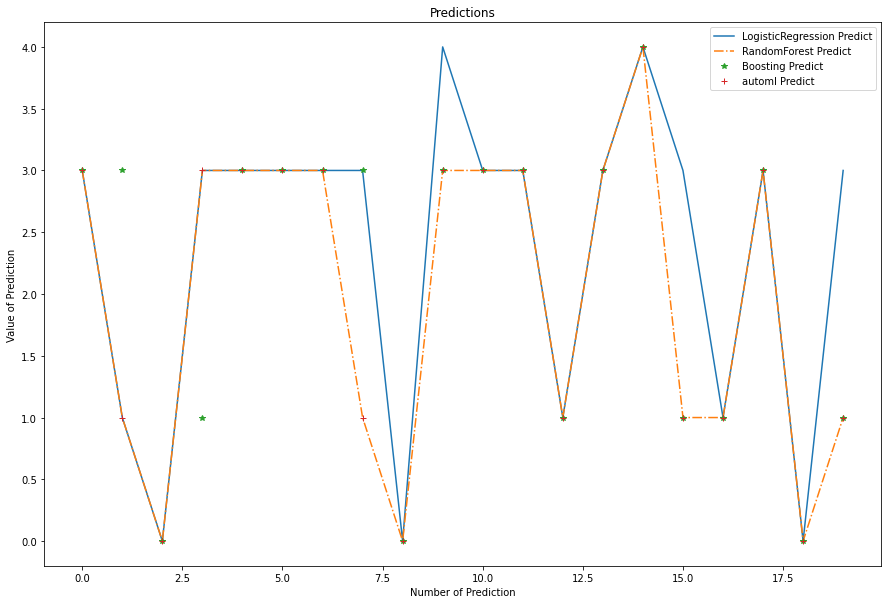

In [45]:
import matplotlib.pyplot as plt
x = list(range(0, len(x_test)))
plt.plot(x[:20], list(logisticReg)[:20], label ='LogisticRegression Predict')
plt.plot(x[:20], list(randomForrest)[:20], '-.', label ='RandomForest Predict')
plt.plot(x[:20], list(gradiantBoosting)[:20], '*', label ='Boosting Predict')
plt.plot(x[:20], list(automlPredict)[:20], '+', label ='automl Predict')

plt.xlabel("Number of Prediction")
plt.ylabel("Value of Prediction")
plt.legend()
plt.title('Predictions')
plt.rcParams["figure.figsize"] = (10,15)
plt.show()

In [359]:
# here we used another approach for detecting players situation we use another Tabel 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score ,r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
# df2 = pd.read_parquet('./HoseinData.parquet',engine='pyarrow')
label = LabelEncoder()
df2['position'] = df2['position'].apply(lambda x: labeling(x))
df2['position'] = label.fit_transform(df2['position'])
x_train, x_test, y_train, y_test = train_test_split(df2.drop(['position','playersId'],axis=1), df2['position'], train_size=.90, random_state=42)
from sklearn.ensemble import RandomForestClassifier
modelForest1 = RandomForestClassifier(n_estimators = 700 ,bootstrap= False,criterion='log_loss'\
    ,max_features='log2',n_jobs=-1)
# finalDf.columns =finalDf.columns.astype(str)
# train3 = finalDf
# train = train3[:6000]
# val = train3[6000:]
modelForest1.fit(x_train , y_train)
modelForest1.get_params()
# model.score(val.drop(['gender'],axis=1),val['gender'])
pred = modelForest1.predict(x_test)
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print(f1_score(y_test,pred,average='macro'))

0.7793226916142921
